In [2]:
import pathlib
from functools import partial

from astropy.convolution import convolve, Gaussian2DKernel
from astropy.constants import G
import astropy.table as at
import astropy.units as u
import cmasher as cmr
import gala.integrate as gi
import gala.dynamics as gd
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyia import GaiaData
from tqdm import tqdm, trange

%matplotlib inline
import numpy as np
from gala.units import galactic
from scipy.interpolate import InterpolatedUnivariateSpline

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import torusimaging as oti
from config import (
    mgfe_cbar_vlim,
    mgfe_cbar_xlim,
    galcen_frame,
    gala_pot,
    agama_pot,
    R0,
    vc0,
)
from model_maker import SplineLabelModelWrapper

import agama

agama.setUnits(mass=u.Msun, length=u.kpc, time=u.Myr)

In [3]:
g = GaiaData("../data/apogee-rgb-sample.fits")

In [4]:
mask_bits = {
    "ASPCAPFLAG": [7, 23],  # STAR_WARN, STAR_BAD
    "STARFLAG": [9, 18, 16, 17, 23],  # PERSIST_HIGH, BAD_RV_COMBINATION, etc.
    # Remove stars targeted in known clusters or dwarf galaxies:
    "APOGEE_TARGET1": [9, 18, 24, 26],
    "APOGEE_TARGET2": [10, 18],
    "APOGEE2_TARGET1": [9, 18, 20, 21, 22, 23, 24, 26],
    "APOGEE2_TARGET2": [10],
    "APOGEE2_TARGET3": [5, 14, 15],
    "MEMBERFLAG": 0,
}

target_mask = np.ones(len(g), dtype=bool)
for name, bits in mask_bits.items():
    if isinstance(bits, (list, np.ndarray)):
        target_mask &= (g[name] & np.sum(2 ** np.array(bits))) == 0
    else:
        target_mask &= g[name] == bits
print(len(target_mask), target_mask.sum())

# g = g[target_mask]

171456 143861


In [5]:
c = g.get_skycoord(radial_velocity=g.VHELIO_AVG * u.km / u.s)
galcen = c.transform_to(galcen_frame)
w = gd.PhaseSpacePosition(galcen.data)

In [6]:
Lz_sun = R0 * vc0
print(Lz_sun)

Lz = np.abs(w.angular_momentum()[2]).to(u.kpc * u.km / u.s)
Rg = (Lz / gala_pot.circular_velocity(w)).to(u.kpc)

# Lz_mask = np.abs(Lz - Lz_sun) < 0.2 * Lz_sun
Lz_mask = np.abs(Rg - 1.1 * R0) < 1 * u.kpc

mask = Lz_mask & target_mask

mask.sum()

1894.9750000000001 km kpc / s


47435

In [7]:
oti_data = oti.OTIData(
    pos=w.z[mask],
    vel=w.v_z[mask],
    labels=dict(mgfe=g.MG_FE[mask]),
    label_errs=dict(mgfe=2 * g.MG_FE_ERR[mask]),
)

In [8]:
init_Omega = 0.077 * u.rad / u.Myr
# max_z = 2.5 * u.kpc
# max_vz = 80.0 * u.km / u.s
z95 = np.nanpercentile(np.abs(oti_data.pos), 95)
vz95 = np.nanpercentile(np.abs(oti_data.vel), 95).to(u.km / u.s)
max_z = 1.2 * z95
max_vz = 1.2 * vz95

max_z, max_vz

(<Quantity 1.6329787 kpc>, <Quantity 51.11603695 km / s>)

In [9]:
max_re = (z95 * np.sqrt(init_Omega)).decompose(galactic)
max_re.value

0.37761100013891824

In [10]:
# zbins = np.linspace(-max_z.value, max_z.value, 151) * u.kpc
# vzbins = np.linspace(-max_vz.value, max_vz.value, 151) * u.km / u.s
zbins = np.linspace(-1, 1, 101) * max_z
vzbins = np.linspace(-1, 1, 101) * max_vz
zvz_bins = {"pos": zbins, "vel": vzbins}

cdata = oti_data.get_binned_counts(zvz_bins)
bdata, _ = oti_data.get_binned_label(bins=zvz_bins)
bdata["mgfe_err"] = np.sqrt(bdata["mgfe_err"] ** 2 + (0.025) ** 2 / cdata["counts"])

/mnt/ceph/users/apricewhelan/projects/torusimaging/torusimaging/data.py:162: RuntimeWarning: invalid value encountered in true_divide
  mean = stat_mean1.statistic / stat_mean2.statistic
/mnt/ceph/users/apricewhelan/projects/torusimaging/torusimaging/data.py:163: RuntimeWarning: divide by zero encountered in true_divide
  err = np.sqrt(1 / stat_mean2.statistic)
/tmp/ipykernel_906794/983952062.py:9: RuntimeWarning: divide by zero encountered in true_divide
  bdata["mgfe_err"] = np.sqrt(bdata["mgfe_err"]**2 + (0.025)**2 / cdata["counts"])


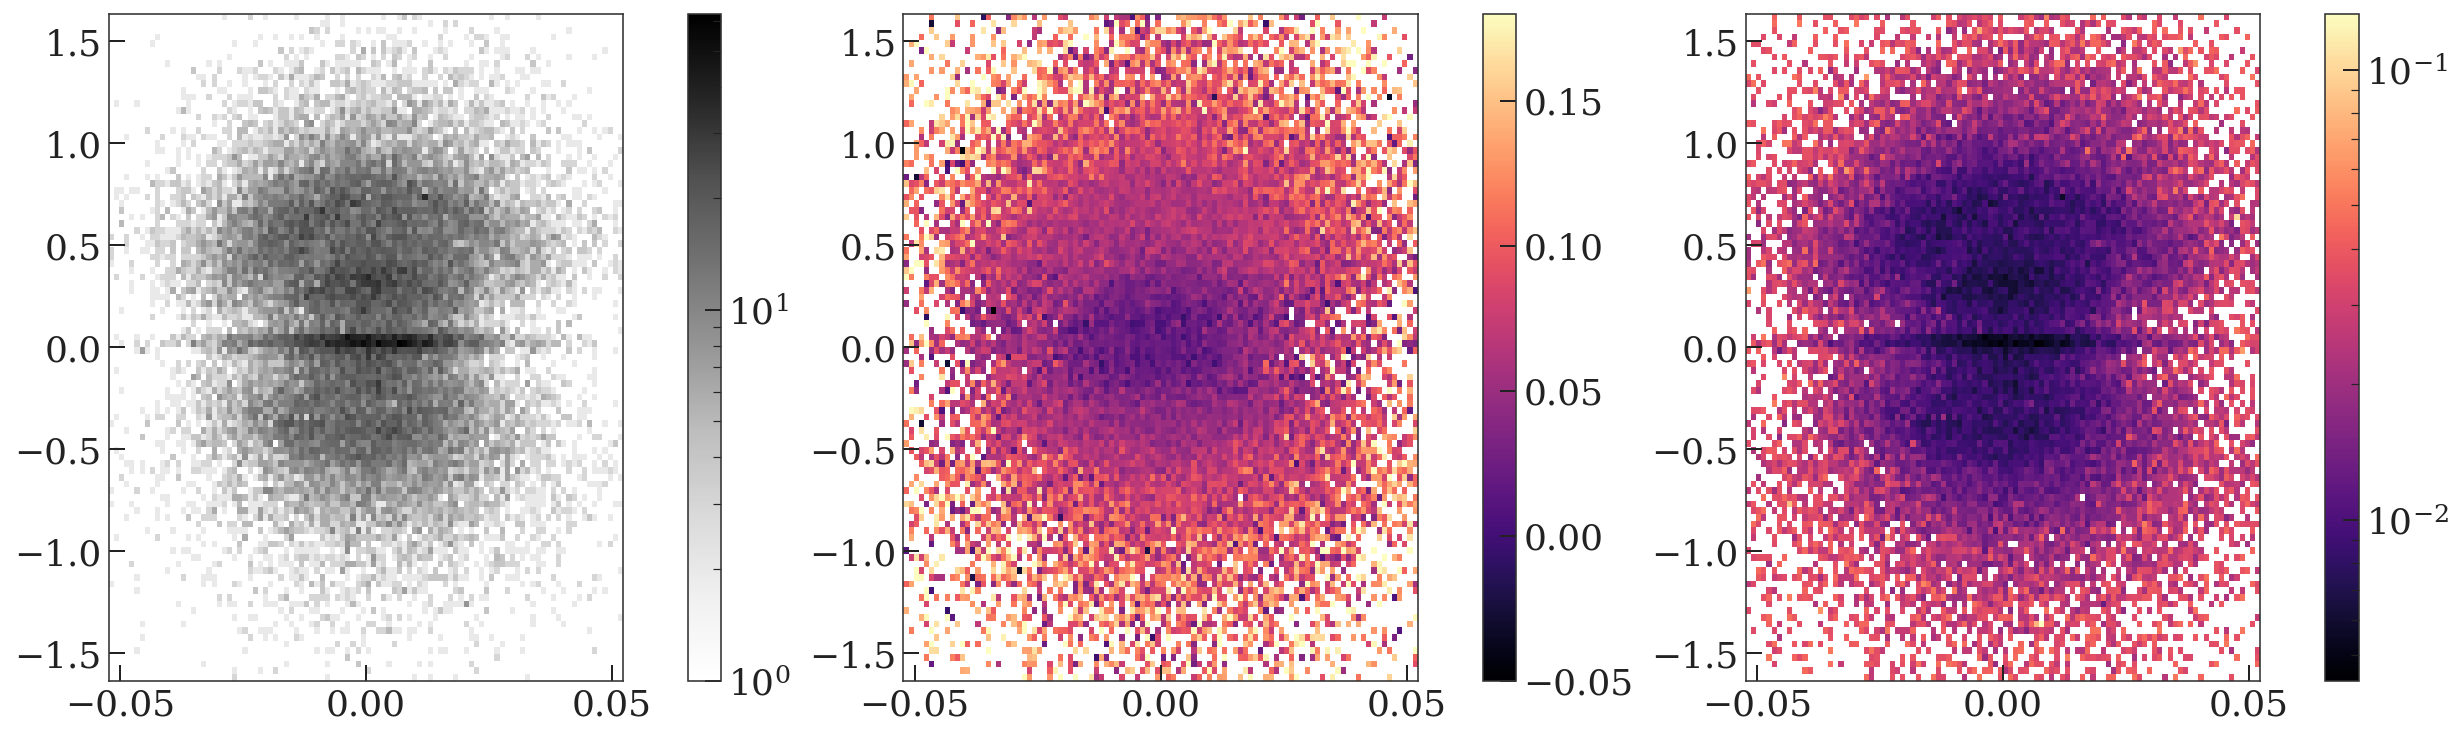

In [11]:
res = oti_data.get_binned_counts(zvz_bins)

fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)
cs = axes[0].pcolormesh(
    bdata["vel"].value,
    bdata["pos"].value,
    res["counts"],
    norm=mpl.colors.LogNorm(),
    cmap="Greys",
)
fig.colorbar(cs, ax=axes[0])

cs = axes[1].pcolormesh(
    bdata["vel"].value,
    bdata["pos"].value,
    bdata["mgfe"],
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
fig.colorbar(cs, ax=axes[1])

cs = axes[2].pcolormesh(
    bdata["vel"].value, bdata["pos"].value, bdata["mgfe_err"], norm=mpl.colors.LogNorm()
)
fig.colorbar(cs, ax=axes[2])

In [73]:
e_n_knots = {2: 15, 4: 7}
model = SplineLabelModelWrapper(
    r_e_max=max_re.value,
    label_n_knots=7,
    label0_bounds=(-1.0, 1.0),
    label_grad_sign=1.0,
    e_n_knots=e_n_knots,
    e_bounds={
        2: {"vals": (np.full(e_n_knots[2] - 1, 0), np.full(e_n_knots[2] - 1, 2))},
        4: {"vals": (np.full(e_n_knots[4] - 1, 0), np.full(e_n_knots[4] - 1, 0.5))},
    },
    #     e_knots_scale={2: (lambda x: x ** (3 / 2), lambda x: x ** (2 / 3))},
    e_regularize_sigmas={2: 0.5, 4: 0.5},
    #     e_regularize=False
    label_model_kwargs=dict(Bisection_kwargs=dict(tol=1e-8, maxiter=256)),
)

In [74]:
p0 = model.get_init_params(oti_data)
p0["ln_Omega0"] = -2.55
p0["pos0"] = 0.02
p0

{'pos0': 0.02,
 'vel0': 0.0006880073755554786,
 'ln_Omega0': -2.55,
 'e_params': {2: {'vals': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)},
  4: {'vals': Array([0., 0., 0., 0., 0., 0.], dtype=float64)}},
 'label_params': {'label_vals': array([0.02859957, 0.43389269, 0.43389269, 0.43389269, 0.43389269,
         0.43389269, 0.43389269])}}

In [75]:
bdata, res = model.run(
    bdata,
    p0=p0,
    bins=zvz_bins,
    label_name="mgfe",
    jaxopt_kw=dict(maxiter=32768, tol=1e-12),
)
res.state.success, res.state.iter_num

(True, 4702)

In [76]:
res.params

{'e_params': {2: {'vals': Array([0.77141175, 0.72164332, 0.72644334, 0.8734617 , 1.08644958,
          1.22265136, 0.93583728, 0.4316534 , 0.11984453, 0.0220978 ,
          0.05998588, 0.35438186, 0.54545591, 0.46878884], dtype=float64)},
  4: {'vals': Array([0.        , 0.33924357, 0.26183907, 0.        , 0.32743836,
          0.5       ], dtype=float64)}},
 'label_params': {'label_vals': Array([0.00844731, 0.40604333, 0.37100177, 0.35674623, 0.29943737,
         0.2667281 , 0.        ], dtype=float64)},
 'ln_Omega0': Array(-2.68879274, dtype=float64),
 'pos0': Array(0.04754504, dtype=float64),
 'vel0': Array(6.48583414e-05, dtype=float64)}

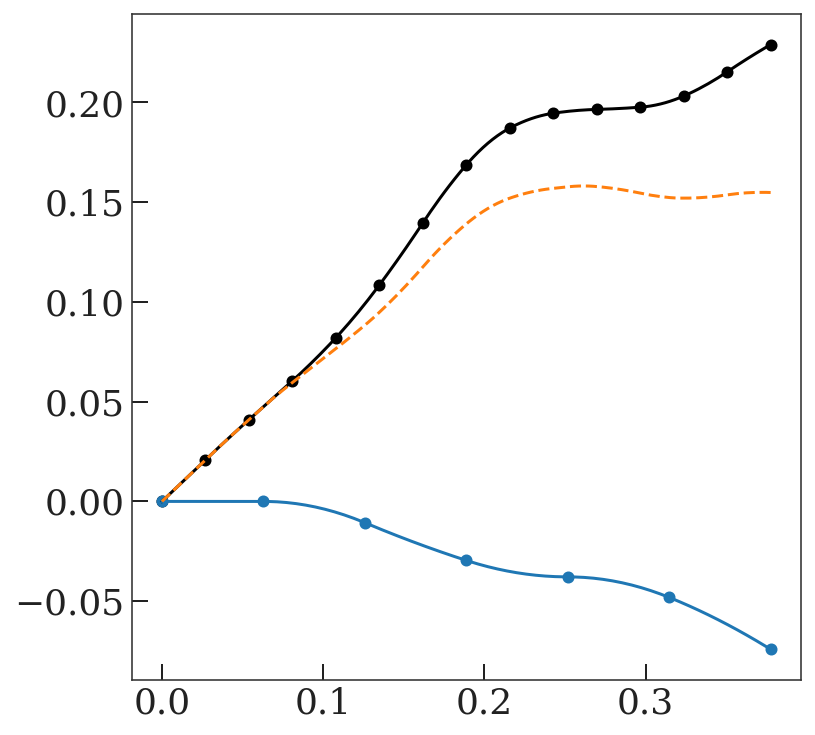

In [77]:
r_e_grid = np.linspace(0, max_re.value, 128)
e_vals = model.label_model.get_es(r_e_grid, res.params["e_params"])

sum_ = None
for m, vals in e_vals.items():
    (l,) = plt.plot(r_e_grid, vals, marker="")
    plt.scatter(
        model.e_knots[m],
        model.label_model.e_funcs[m](
            model.e_knots[m], res.params["e_params"][m]["vals"]
        ),
        color=l.get_color(),
    )

    if sum_ is None:
        sum_ = vals
    else:
        sum_ += vals

plt.plot(r_e_grid, sum_, ls="--", marker="")

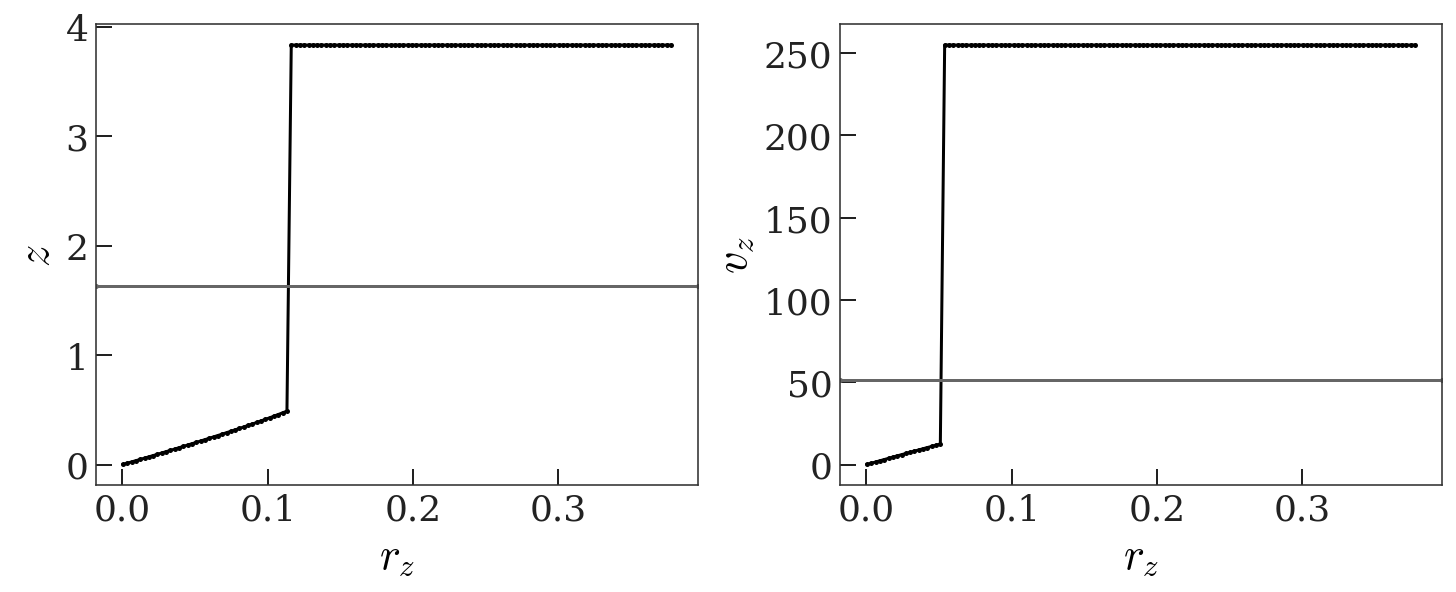

In [78]:
r_grid = np.linspace(1e-3, 1.0, 128) * max_re.value
shit = np.array([model.label_model.get_pos(rr, np.pi / 2, res.params) for rr in r_grid])
fuck = np.array([model.label_model.get_vel(rr, 0.0, res.params) for rr in r_grid])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4), layout="constrained")

ax = axes[0]
ax.plot(r_grid, shit)
ax.axhline(max_z.value)
ax.set_ylabel("$z$")

ax = axes[1]
ax.plot(r_grid, (fuck * u.kpc / u.Myr).to_value(u.km / u.s))
ax.axhline(max_vz.to_value(u.km / u.s))
ax.set_ylabel("$v_z$")

for ax in axes:
    ax.set_xlabel("$r_z$")

In [79]:
r_e, _ = model.label_model.get_elliptical_coords(
    bdata["pos"].ravel(), bdata["vel"].ravel(), res.params
)
r_e.max()

Array(0.47721714, dtype=float64)

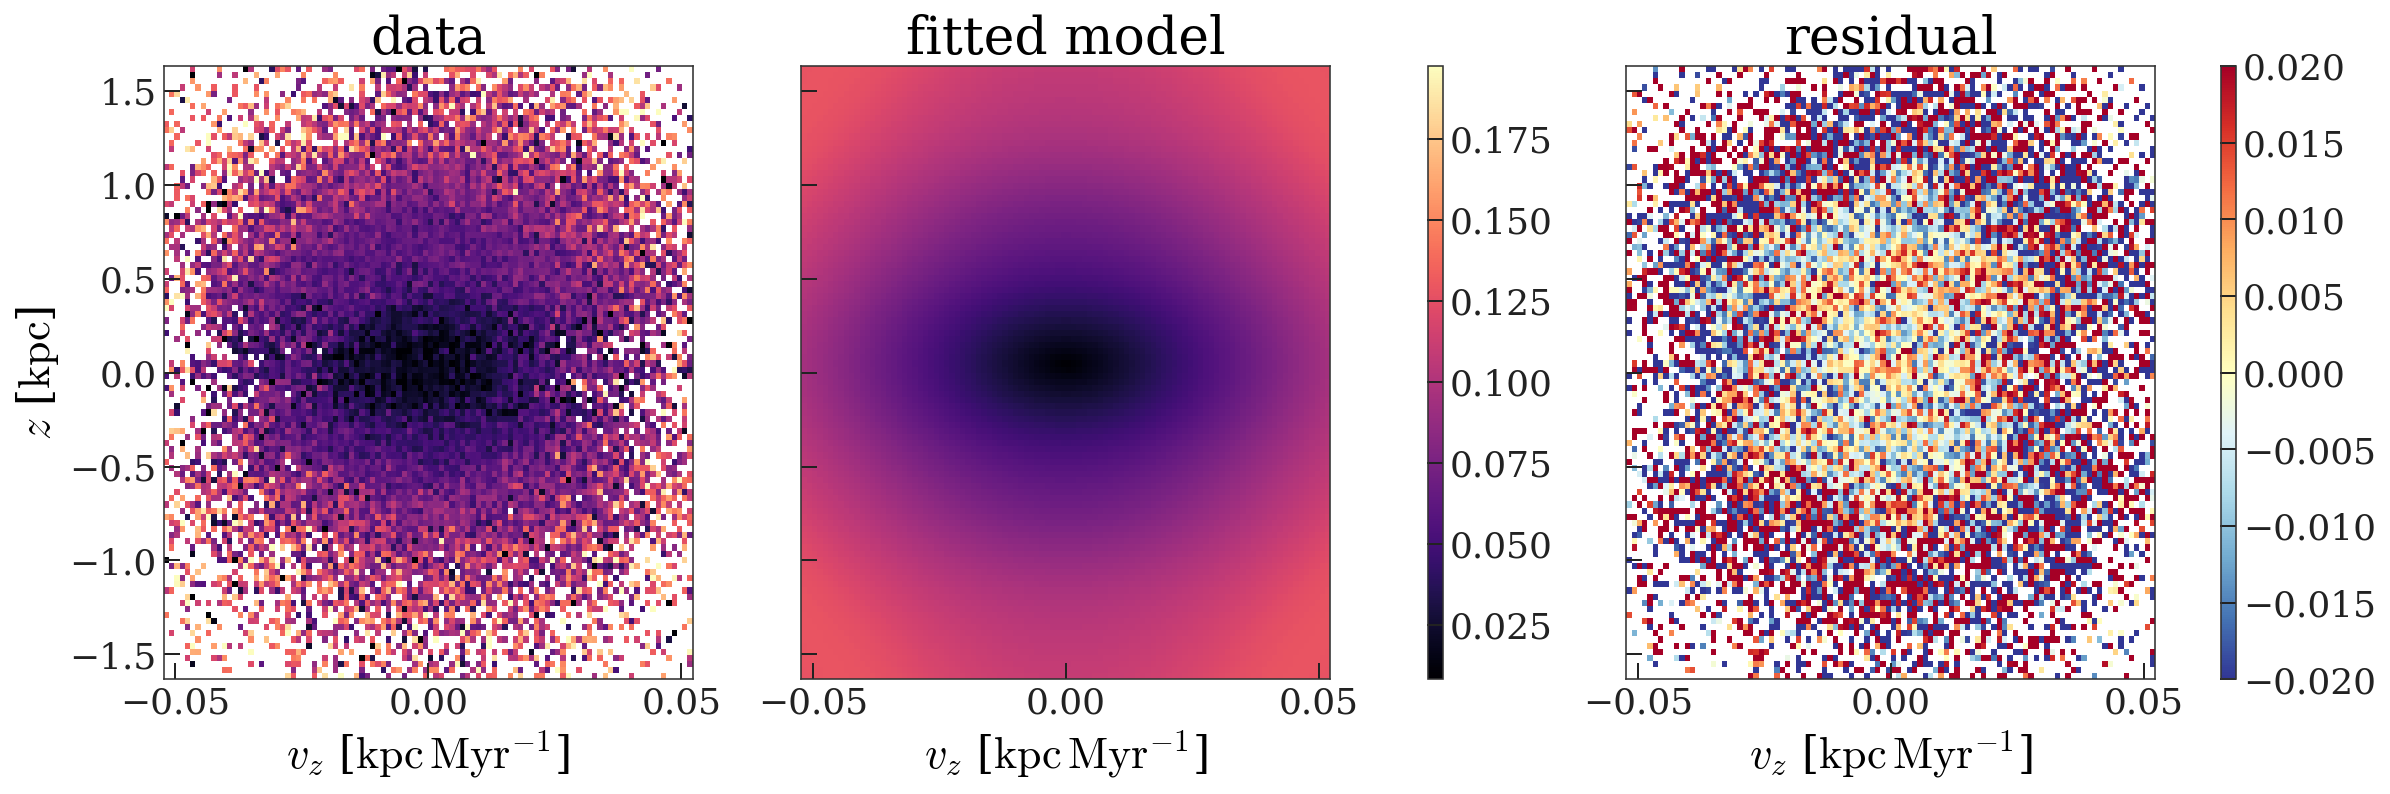

In [80]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata,
    model.label_model,
    res.params,
    label_name="mgfe",
    fractional_residual=False,
    vlim_residual=0.02,
)

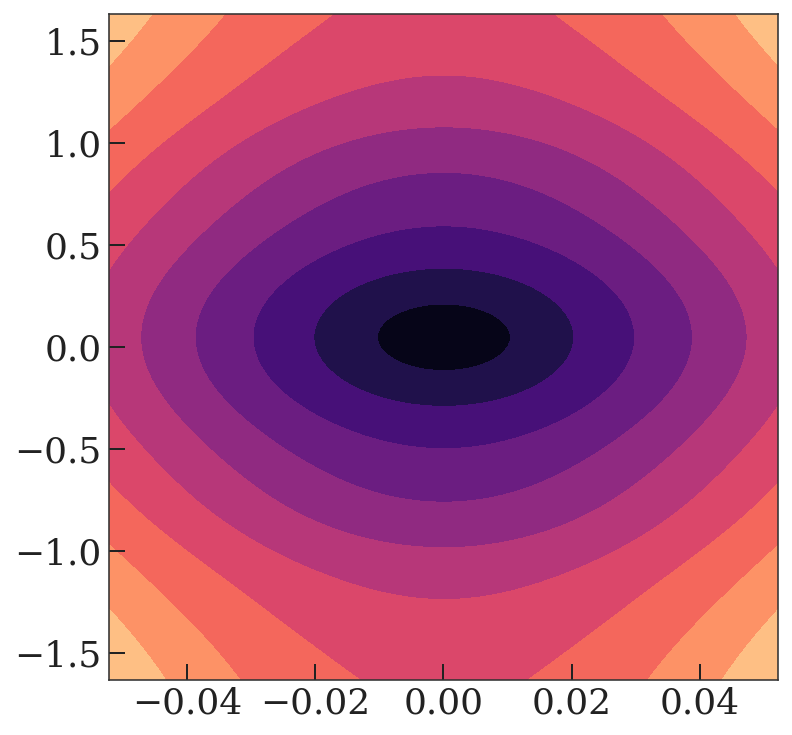

In [93]:
pp, vv = np.meshgrid(
    zvz_bins["pos"].decompose(galactic).value, zvz_bins["vel"].decompose(galactic).value
)
r_e, th_e = model.label_model.get_elliptical_coords(pp, vv, res.params)
r = model.label_model.get_r(r_e, th_e, res.params["e_params"])

plt.contourf(vv, pp, r, levels=np.linspace(0, 1.2 * max_re.value, 12))

In [95]:
model.label_model.check_e_funcs(res.params["e_params"], r_e_max=max_re.value)

(True,
 array([[ 0.00154282,  0.00154235,  0.00154094, ..., -0.00154094,
         -0.00154235, -0.00154282],
        [ 0.00766415,  0.00766181,  0.00765477, ..., -0.00765477,
         -0.00766181, -0.00766415],
        [ 0.01844476,  0.01843912,  0.01842219, ..., -0.01842219,
         -0.01843912, -0.01844476],
        ...,
        [ 0.11515225,  0.11520497,  0.11536286, ..., -0.30609902,
         -0.30664414, -0.30682595],
        [ 0.16401206,  0.16412489,  0.16446292, ..., -0.5180098 ,
         -0.51897486, -0.51929675],
        [ 0.14307625,  0.1432738 ,  0.14386572, ..., -0.66724494,
         -0.66858208, -0.66902809]]))

WTF?

In [70]:
import copy

params = copy.deepcopy(res.params)
# params['e_params'][2]['vals'] = np.array(1. * params['e_params'][2]['vals'])
# params['e_params'][2]['vals'] = np.zeros_like(params['e_params'][2]['vals'])
# params['e_params'][4]['vals'] = np.zeros_like(params['e_params'][4]['vals'])
# params['label_params']['label_vals'] = np.zeros_like(params['label_params']['label_vals'])
for k, v in params.items():
    print(k, v)

e_params {2: {'vals': Array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.4050125 , 0.25294158, 0.2000097 ,
       0.34385628, 0.5       , 0.5       , 0.48382921], dtype=float64)}, 4: {'vals': Array([1.64753242e-02, 4.72715624e-01, 3.11381775e-01, 1.47316764e-04,
       4.01299658e-01, 5.00000000e-01], dtype=float64)}}
label_params {'label_vals': Array([0.00802859, 0.41631603, 0.33752694, 0.34491939, 0.29074395,
       0.27210278, 0.        ], dtype=float64)}
ln_Omega0 -2.7971953866978234
pos0 0.048388070961731144
vel0 9.54204549379373e-05


In [71]:
model.label_model.get_pos(0.1, np.pi / 2, params)

Array(4.04951732, dtype=float64)

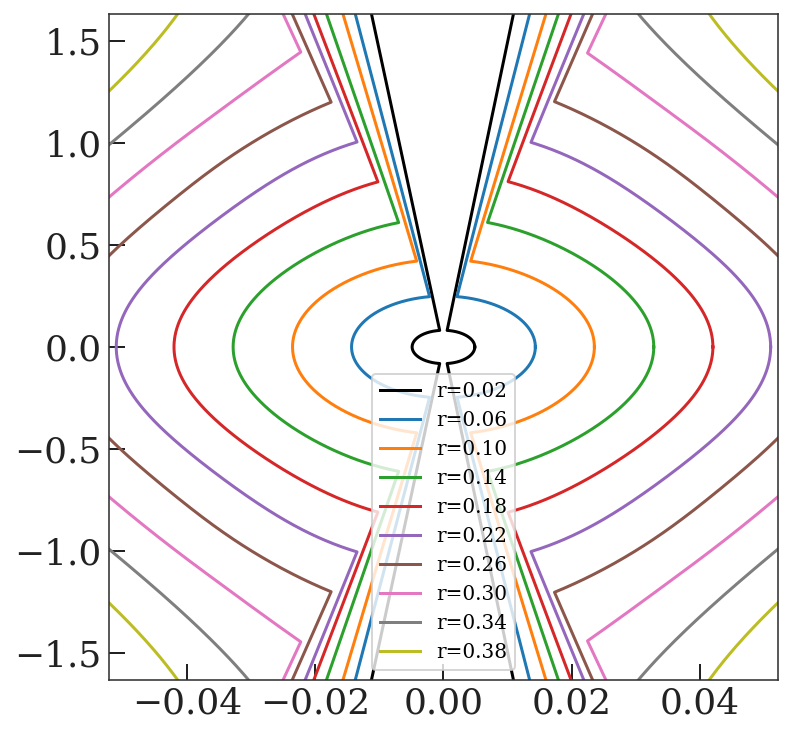

In [72]:
get_pos_vec = jax.vmap(model.label_model.get_pos, in_axes=[None, 0, None])
get_vel_vec = jax.vmap(model.label_model.get_vel, in_axes=[None, 0, None])

th_e = np.linspace(0, 2 * np.pi, 1024)

for r in np.linspace(0.02, max_re.value, 10):
    pp = get_pos_vec(r, th_e, params)
    vv = get_vel_vec(r, th_e, params)
    plt.plot(vv, pp, marker="", label=f"r={r:.2f}")

plt.xlim(-max_vz.decompose(galactic).value, max_vz.decompose(galactic).value)
plt.ylim(-max_z.decompose(galactic).value, max_z.decompose(galactic).value)
plt.legend()

In [49]:
Omega = np.exp(res.params["ln_Omega0"]) * u.rad / u.Myr

In [50]:
a_unit = u.km / u.s / u.Myr
zgrid = np.linspace(-1, 1, 512) * z95

Error samples:

In [51]:
tmp_data = bdata.copy()
tmp_data["label"] = tmp_data.pop("mgfe")
tmp_data["label_err"] = tmp_data.pop("mgfe_err")
tmp_mask = np.logical_and.reduce([np.isfinite(tmp_data[k]) for k in tmp_data])
tmp_data = {k: tmp_data[k][tmp_mask] for k in tmp_data}

errs = model.label_model.error_propagate_uncertainty(res.params, tmp_data)
errs

{'e_params': {2: {'vals': Array([1.01299401, 2.23386566, 1.567928  , 1.25625761, 1.04377824,
          0.89299387, 0.78894894, 0.89778938, 0.        , 0.        ,
          1.14782333, 0.86875295, 0.99744954, 1.50896276], dtype=float64)},
  4: {'vals': Array([0.12592301, 0.31363449, 0.        , 0.        , 0.        ,
          1.68773727], dtype=float64)}},
 'label_params': {'label_vals': Array([0.0005365 , 0.00837811, 0.00769928, 0.        , 0.        ,
         0.05244162, 0.        ], dtype=float64)},
 'ln_Omega0': Array([0.], dtype=float64),
 'pos0': Array([0.0018525], dtype=float64),
 'vel0': Array([0.00011997], dtype=float64)}

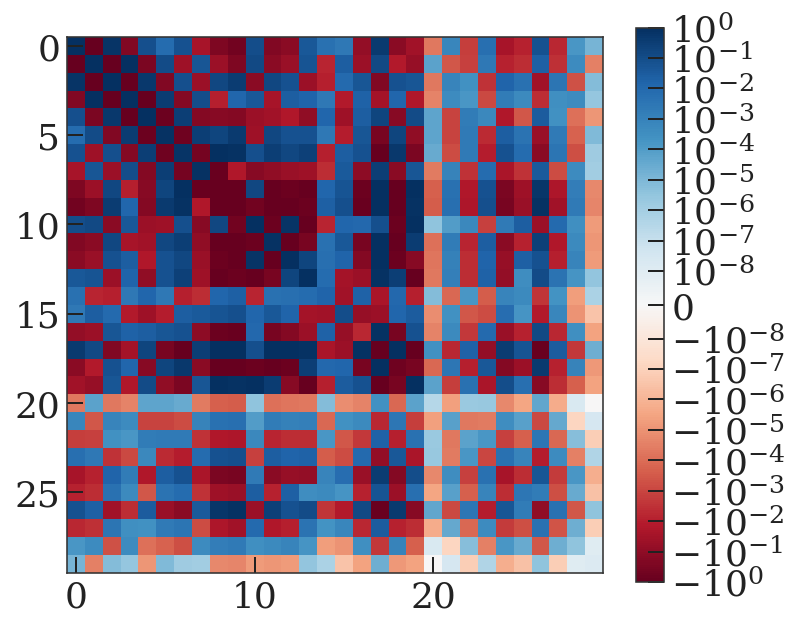

In [52]:
M = model.label_model.get_crlb(res.params, tmp_data)  # , inv=True)

plt.figure(figsize=(6, 5))
plt.imshow(M, norm=mpl.colors.SymLogNorm(1e-8, vmin=-1e0, vmax=1e0), cmap="RdBu")
plt.colorbar()

In [53]:
par_samples = model.label_model.get_crlb_error_samples(res.params, tmp_data, size=1024)

In [54]:
res_vals, treedef = jax.tree_util.tree_flatten(res.params)

clean_par_samples = []
for p in par_samples:
    tmp, _ = jax.tree_util.tree_flatten(p)

    tmp_flat = []
    for v, res_v in zip(tmp, res_vals):
        v = np.atleast_1d(v).copy()
        res_v = np.atleast_1d(res_v)
        v[~np.isfinite(v)] = res_v[~np.isfinite(v)]
        v = np.squeeze(v)
        tmp_flat.append(v)
    p = jax.tree_util.tree_unflatten(treedef, tmp_flat)
    clean_par_samples.append(p)

In [55]:
oti_accs = []
# for p in par_samples:
for p in tqdm(clean_par_samples):
    acc = model.label_model.get_acceleration(zgrid, p)
    oti_accs.append(acc.value)
oti_accs = oti_accs * acc.unit

100%|██████████| 1024/1024 [00:07<00:00, 132.09it/s]


Bootstrap trials:

In [125]:
rng = np.random.default_rng(seed=8675309)
trials = []
for trial in trange(8):
    trial_idx = rng.choice(len(oti_data), size=len(oti_data), replace=True)
    _, trial_res = model.run(
        oti_data[trial_idx], bins=zvz_bins, jaxopt_kw=dict(maxiter=4096, tol=1e-8)
    )
    trials.append(trial_res)

100%|██████████| 8/8 [01:21<00:00, 10.24s/it]


In [126]:
bootstrap_accs = []
for trial_res in trials:
    acc = model.label_model.get_acceleration(zgrid, trial_res.params)
    bootstrap_accs.append(acc.value)
bootstrap_accs = bootstrap_accs * acc.unit

Total err:

In [56]:
xyz_grid = np.zeros((3, zgrid.size)) * u.kpc
xyz_grid[0] = 1.1 * R0
xyz_grid[2] = zgrid
true_acc = gala_pot.acceleration(xyz_grid)

In [57]:
err_prop_err = np.diff(
    np.nanpercentile(oti_accs.T, [16, 84], axis=1).to_value(a_unit), axis=0
)[0]
# bootstrap_err = np.std(bootstrap_accs.to_value(a_unit), axis=0)
# total_acc_err = np.sqrt(err_prop_err**2 + bootstrap_err**2) * a_unit
# total_acc_err = bootstrap_err * a_unit
total_acc_err = err_prop_err * a_unit

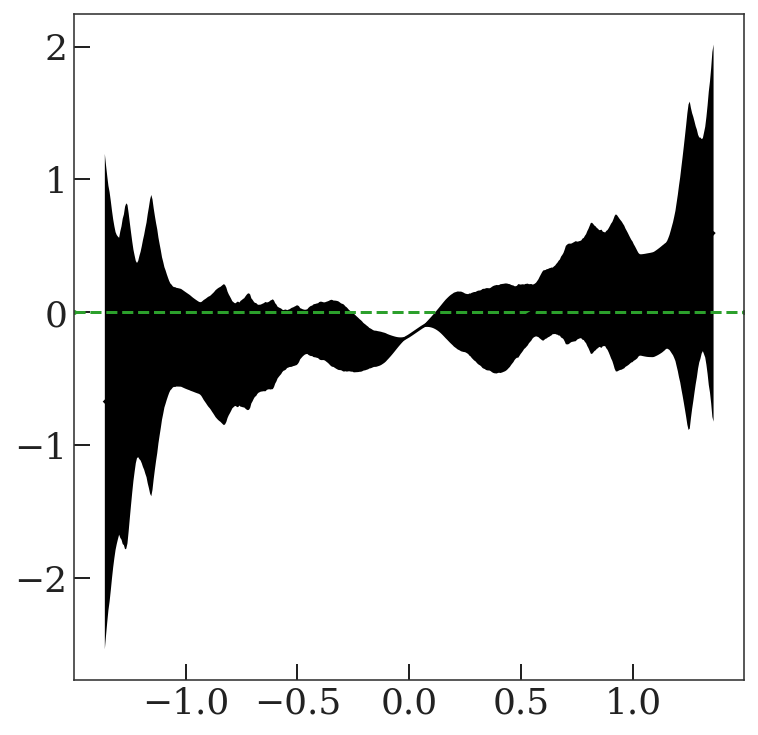

In [58]:
tmp = res.params.copy()
# tmp['pos0'] = 0.
bestfit_acc = model.label_model.get_acceleration(
    zgrid + res.params["pos0"] * u.kpc, tmp
)

dacc = (bestfit_acc - true_acc[2]).to_value(a_unit)

plt.axhline(0.0, ls="--", color="tab:green")
plt.plot(zgrid.value, dacc, marker="", color="k")
plt.fill_between(
    zgrid.value,
    dacc - total_acc_err.to_value(a_unit),
    dacc + total_acc_err.to_value(a_unit),
)
# plt.fill_between(
#     zgrid.value,
#     (np.nanpercentile(oti_accs.T, 16, axis=1) - true_acc[2]).to_value(a_unit),
#     (np.nanpercentile(oti_accs.T, 84, axis=1) - true_acc[2]).to_value(a_unit),
# )
# plt.ylim(-0.1, 0.1)

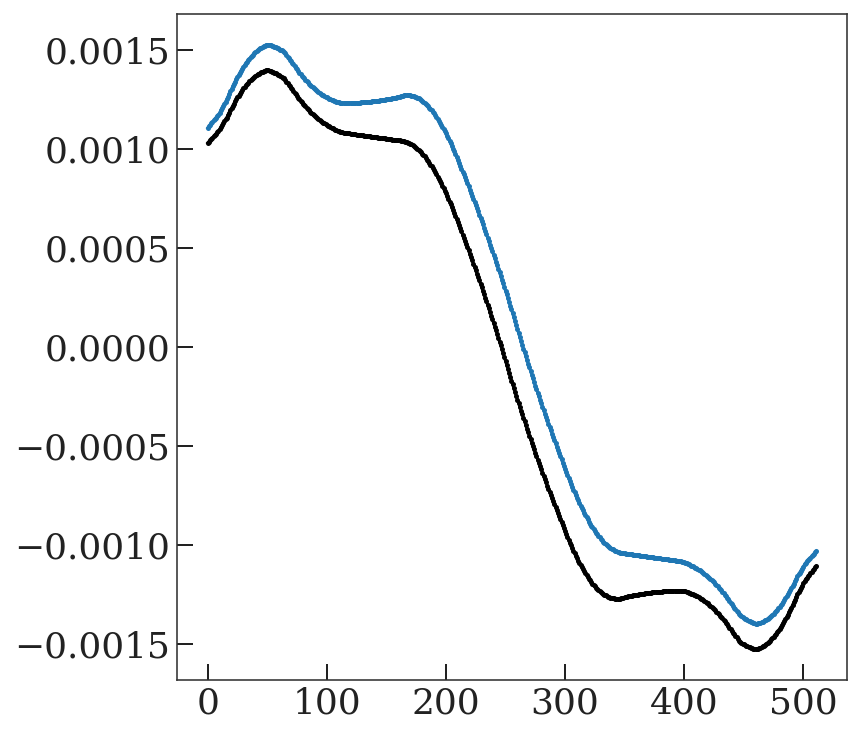

In [59]:
plt.plot(bestfit_acc)
plt.plot(-bestfit_acc[::-1])

In [60]:
# bestfit_acc = model.label_model.get_acceleration(zgrid, res.params)

# dacc = ((bestfit_acc - true_acc[2]) / true_acc[2]).decompose().value

# plt.plot(zgrid.value, dacc, marker="", ls="--", color="tab:green")

# colors = ['tab:blue', 'tab:orange', 'tab:red']
# for i, (m, knots) in enumerate(model.e_knots.items()):
#     for k in knots:
#         rr = model.label_model.get_r(k, np.pi/2, res.params['e_params'])
#         zz = model.label_model.get_pos(rr, np.pi/2, res.params)

#         plt.axvline(zz, color=colors[i])
#         plt.axvline(-zz, color=colors[i])

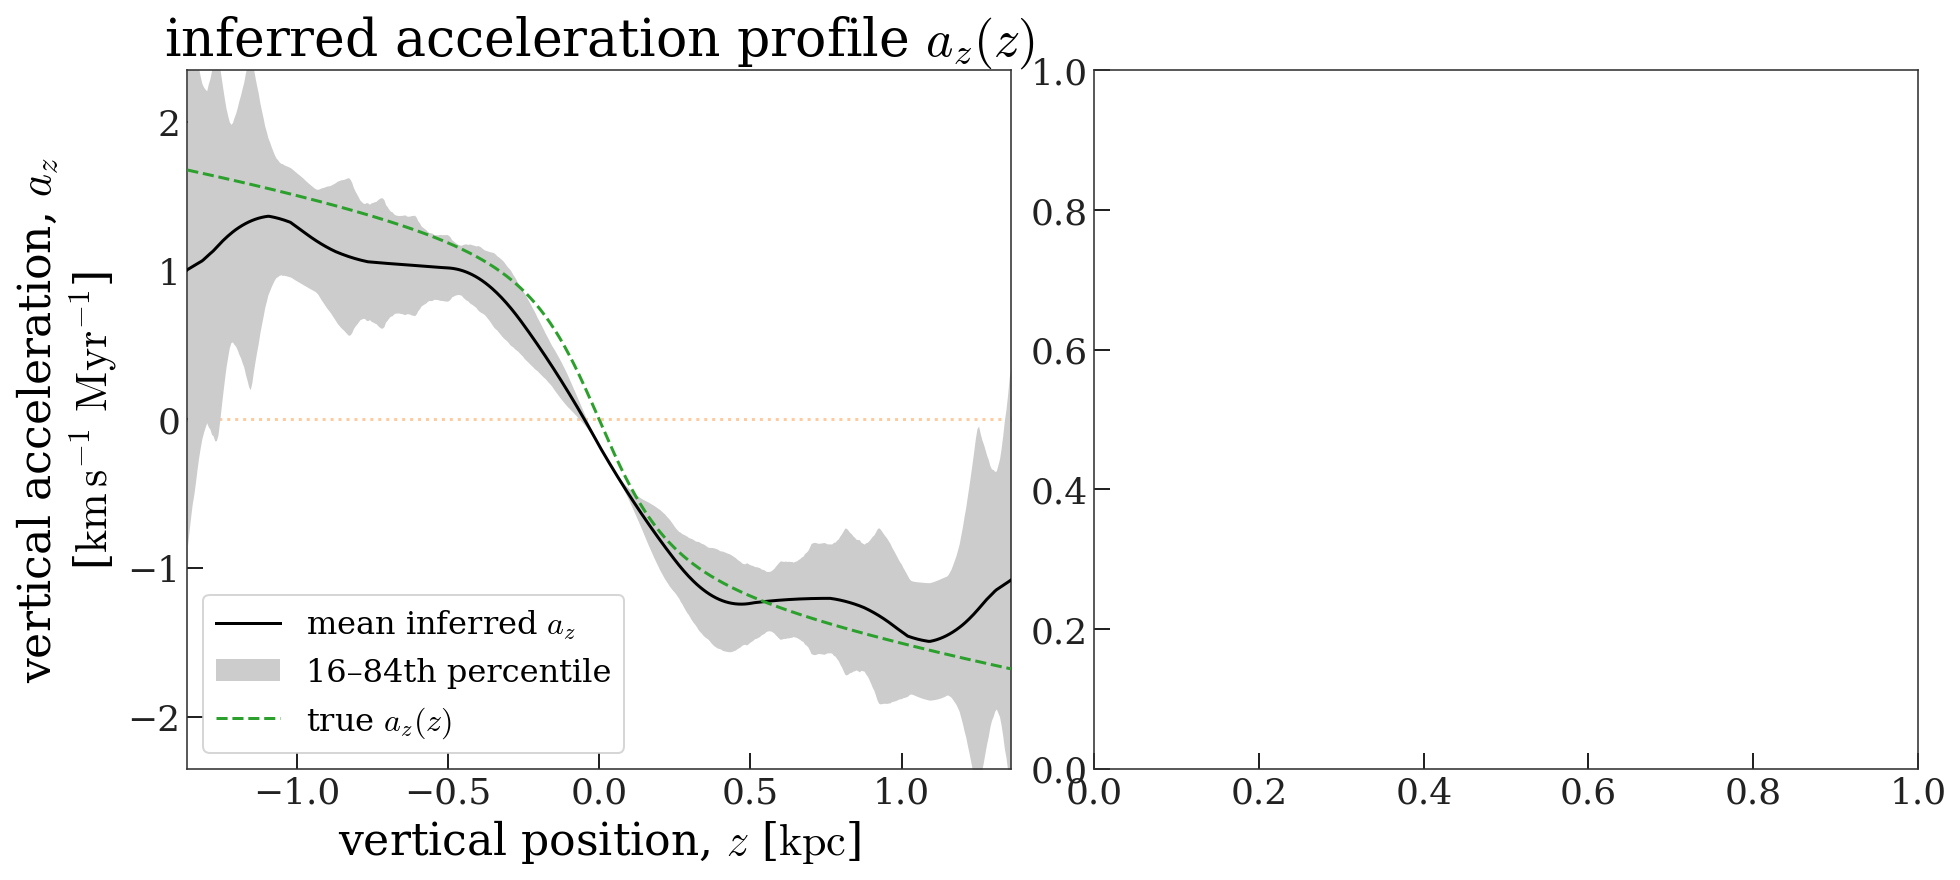

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(13.5, 6.0), layout="constrained")

ax = axes[0]
ax.plot(
    zgrid.value,
    bestfit_acc.to_value(a_unit),
    # np.nanmean(oti_accs.T, axis=1).to_value(a_unit),
    color="k",
    marker="",
    label="mean inferred $a_z$",
    zorder=10,
)
ax.fill_between(
    zgrid.value,
    # np.nanpercentile(oti_accs.T, 16, axis=1).value,
    # np.nanpercentile(oti_accs.T, 84, axis=1).value,
    (bestfit_acc - total_acc_err).to_value(a_unit),
    (bestfit_acc + total_acc_err).to_value(a_unit),
    color="#cccccc",
    lw=0,
    label=r"16–84th percentile",
    zorder=2,
)
ax.plot(
    zgrid.value,
    true_acc[2].to_value(a_unit),
    ls="--",
    color="tab:green",
    marker="",
    label=r"true $a_z(z)$",
    zorder=15,
)
ax.set_xlim(zgrid.value.min(), zgrid.value.max())
ax.set_ylim(
    1.4 * true_acc[2].min().to_value(a_unit), 1.4 * true_acc[2].max().to_value(a_unit)
)
ax.axhline(0, zorder=-10, color="tab:orange", alpha=0.4, ls=":")
ax.legend(loc="lower left", fontsize=16)

ax.set_xlabel(f"vertical position, $z$ [{u.kpc:latex}]")
ax.set_ylabel(
    f"vertical acceleration, $a_z$\n[{u.km/u.s:latex_inline} {u.Myr**-1:latex_inline}]"
)
ax.set_title("inferred acceleration profile $a_z(z)$")

ax = axes[1]
# ax.plot(
#     aaf["J"].to_value(Junit),
#     pdata["J"].to_value(Junit)[aaf_idx, 2],
#     marker="o",
#     ls="none",
#     alpha=0.25,
#     mew=0,
#     ms=2.0,
#     label="particle $J_z$ values",
#     rasterized=True,
# )
# ax.axline(
#     [0, 0],
#     [
#         pdata["J"].to_value(Junit)[aaf_idx, 2].max(),
#         pdata["J"].to_value(Junit)[aaf_idx, 2].max(),
#     ],
#     ls="--",
#     color="tab:green",
#     marker="",
#     label="one-to-one line",
# )
# ax.set_xlim(0, pdata["J"].to_value(Junit)[idx, 2].max())
# ax.set_ylim(0, pdata["J"].to_value(Junit)[idx, 2].max())
# ax.set_title("inferred vertical actions $J_z$")

# ax.legend(loc="lower right", fontsize=16)

# ax.set_xlabel(f"inferred $J_z$ [{Junit:latex_inline}]")
# ax.set_ylabel(f"true $J_z$ [{Junit:latex_inline}]")
# ax.set_xticks(np.arange(0, 200, 50))
# ax.set_yticks(np.arange(0, 200, 50))

# fig.savefig("../tex/figures/qiso-validation.pdf", dpi=250)

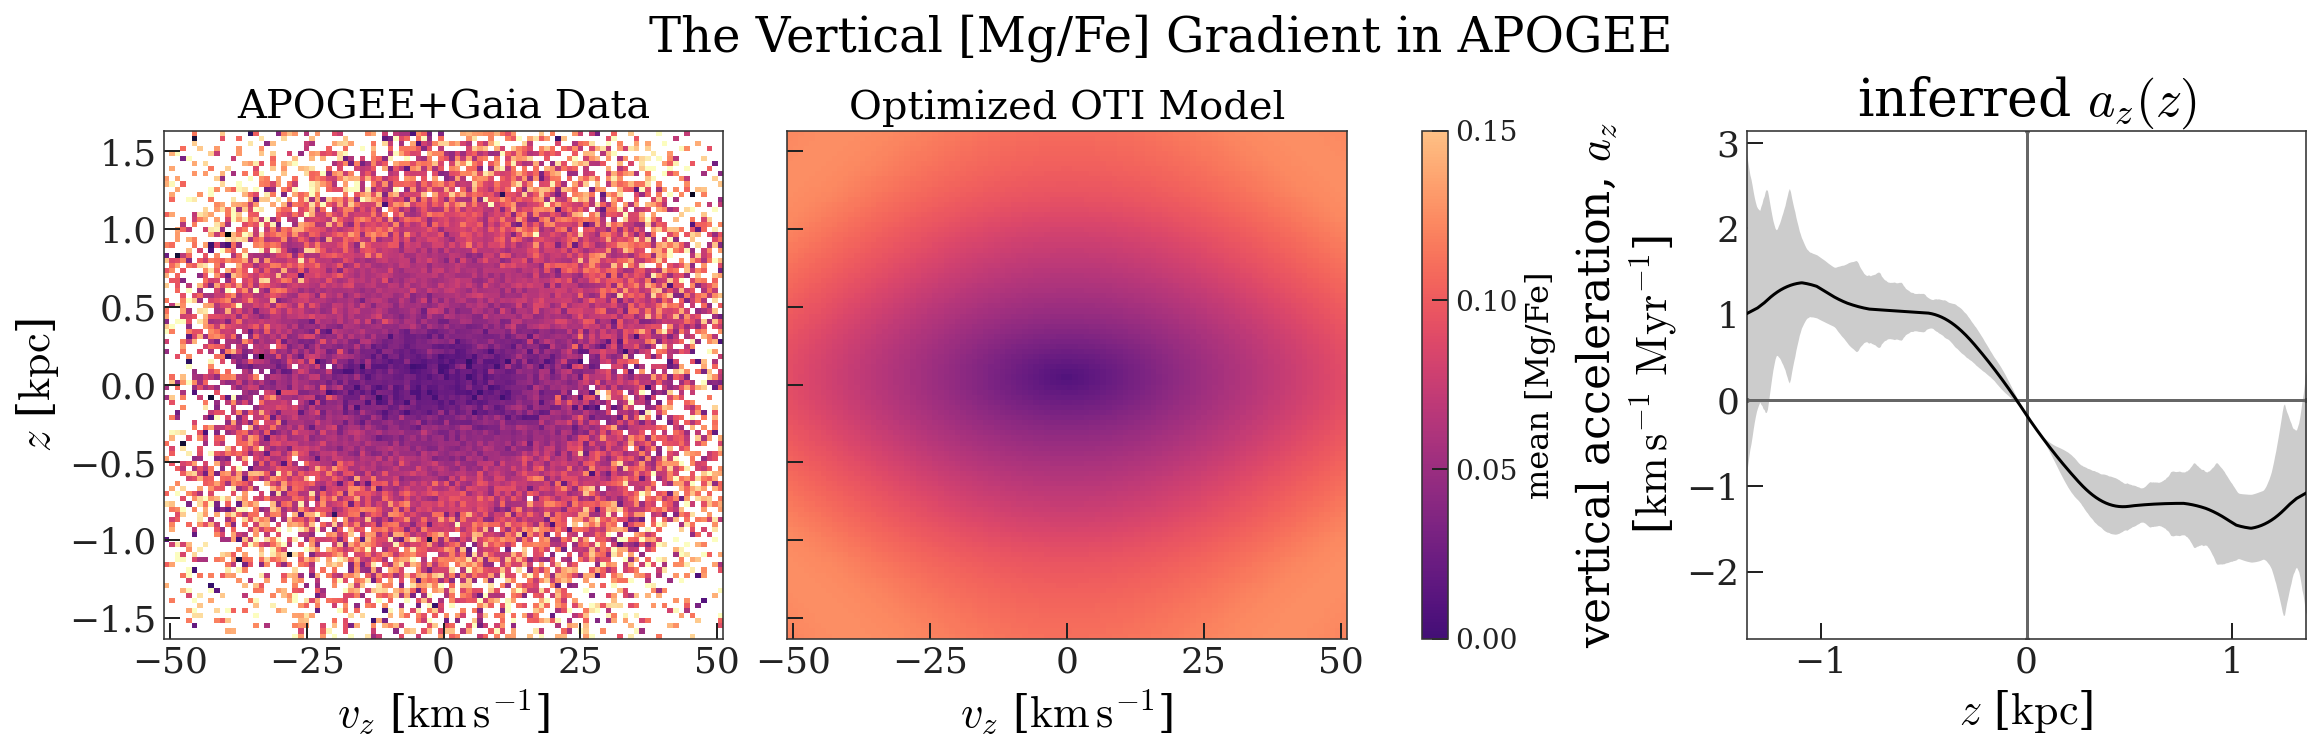

In [62]:
cb_labelsize = 16

fig, axes = plt.subplots(1, 3, figsize=(16, 5.1), layout="constrained")

cs = axes[0].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["mgfe"],
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
cb = fig.colorbar(cs, ax=axes[0:2])  # , orientation="horizontal", aspect=40)
cb.set_label("mean [Mg/Fe]", fontsize=cb_labelsize)
cb.ax.set_ylim(mgfe_cbar_xlim)
cb.ax.set_yticks(np.arange(mgfe_cbar_xlim[0], mgfe_cbar_xlim[1] + 1e-3, 0.05))
cb.ax.yaxis.set_tick_params(labelsize=14)


model_mgfe = np.array(model.label_model.label(bdata["pos"], bdata["vel"], res.params))
cs = axes[1].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    model_mgfe,
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
# cb = fig.colorbar(cs, ax=axes[1], orientation="horizontal")
# cb.set_label("number density", fontsize=cb_labelsize)


ax = axes[2]
ax.plot(
    zgrid.value,  # + res.params['pos0'],
    bestfit_acc.to_value(a_unit),
    # np.nanmean(oti_accs.T, axis=1).to_value(a_unit),
    color="k",
    marker="",
    label="mean inferred $a_z$",
    zorder=10,
)
ax.fill_between(
    zgrid.value,  # + res.params['pos0'],
    # np.nanpercentile(oti_accs.T, 16, axis=1).value,
    # np.nanpercentile(oti_accs.T, 84, axis=1).value,
    (bestfit_acc - total_acc_err).to_value(a_unit),
    (bestfit_acc + total_acc_err).to_value(a_unit),
    color="#cccccc",
    lw=0,
    label=r"16–84th percentile",
    zorder=2,
)
ax.set_ylabel(
    f"vertical acceleration, $a_z$\n[{u.km/u.s:latex_inline} {u.Myr**-1:latex_inline}]"
)
ax.set_xlim(-z95.value, z95.value)

# Titles
axes[0].set_title("APOGEE+Gaia Data", fontsize=20)
axes[1].set_title("Optimized OTI Model", fontsize=20)
axes[2].set_title("inferred $a_z(z)$")

fig.suptitle("The Vertical [Mg/Fe] Gradient in APOGEE", fontsize=24)

# Labels
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
for ax in axes[:-1]:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
axes[2].set_xlabel(f"$z$ [{u.kpc:latex_inline}]")

# Ticks
for ax in axes[:2]:
    ax.set_xticks(np.arange(-50, 50 + 1, 25))
    ax.set_yticks(np.arange(-1.5, 1.5 + 1e-3, 0.5))
axes[1].set_yticklabels(["" for _ in axes[1].get_yticklabels()])

axes[2].axvline(0)
axes[2].axhline(0)

# fig.savefig(
#     "../tex/figures/apogee-gaia-fit.pdf", dpi=250, pad_inches=0.1, bbox_inches="tight"
# )